Import the necessary modules and csv file for 2019.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from collections import defaultdict
%matplotlib inline

df = pd.read_csv('./2019/survey_results_public.csv')
schema = pd.read_csv('./2019/survey_results_schema.csv')

Give a quick view of the data

In [3]:
df.head()

,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,...,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
0,1,I am a student who is learning to code,Yes,Never,The quality of OSS and closed source software ...,"Not employed, and not looking for work",United Kingdom,No,Primary/elementary school,NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,14.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
1,2,I am a student who is learning to code,No,Less than once per year,The quality of OSS and closed source software ...,"Not employed, but looking for work",Bosnia and Herzegovina,"Yes, full-time","Secondary school (e.g. American high school, G...",NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,19.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
2,3,"I am not primarily a developer, but I write co...",Yes,Never,The quality of OSS and closed source software ...,Employed full-time,Thailand,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Web development or web design,...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,28.0,Man,No,Straight / Heterosexual,NaN,Yes,Appropriate in length,Neither easy nor difficult
3,4,I am a developer by profession,No,Never,The quality of OSS and closed source software ...,Employed full-time,United States,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,22.0,Man,No,Straight / Heterosexual,White or of European descent,No,Appropriate in length,Easy
4,5,I am a developer by profession,Yes,Once a month or more often,"OSS is, on average, of HIGHER quality than pro...",Employed full-time,Ukraine,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,30.0,Man,No,Straight / Heterosexual,White or of European descent;Multiracial,No,Appropriate in length,Easy


Lets take a look at the stats for this data set to get a feel for what we are looking at.

In [4]:
num_rows = df.shape[0] #Provide the number of rows in the dataset
num_cols = df.shape[1] #Provide the number of columns in the dataset
num_rows, num_cols

(88883, 85)

Do we have any columns with missing values?

In [5]:
no_nulls = set(df.columns[df.isnull().mean()==0]) #Provide a set of columns with 0 missing values.
no_nulls

{'Hobbyist', 'OpenSourcer', 'Respondent'}

In [6]:
most_missing_cols = df.columns[df.isnull().mean() > 0.25]#Provide a set of columns with more than 72% of the values missing
most_missing_cols

Index(['MgrIdiot', 'MgrMoney', 'MgrWant', 'CompTotal', 'CompFreq',
       'ConvertedComp', 'WorkWeekHrs', 'CodeRevHrs', 'UnitTests',
       'PurchaseHow', 'PurchaseWhat', 'WebFrameWorkedWith',
       'WebFrameDesireNextYear', 'MiscTechWorkedWith',
       'MiscTechDesireNextYear', 'BlockchainOrg', 'BlockchainIs'],
      dtype='object')

In [7]:
def get_description(column_name, schema=schema):
    '''
    INPUT - schema - pandas dataframe with the schema of the developers survey
            column_name - string - the name of the column you would like to know about
    OUTPUT - 
            desc - string - the description of the column
    '''
    desc = list(schema[schema['Column'] == column_name]['QuestionText'])[0]
    return desc

#test your code
#Check your function against solution - you shouldn't need to change any of the below code
get_description(df.columns[0]) # This should return a string of the first column description

'Randomized respondent ID number (not in order of survey response time)'

In [8]:
get_description('DevType')

'Which of the following describe you? Please select all that apply.'

In [21]:
#dev_type_vals = df.DevType.value_counts()#Provide a pandas series of the counts for each CousinEducation status

#dev_type_vals # assure this looks right

Remove any rows that have null values for the DevType column as this value is key to answering the questions.  The original dataframe had 88883 rows while the new one minus nulls in the DevType has 81335.

In [10]:
df = df[df['DevType'].notnull()]
df.shape

(81335, 85)

Lets focus on the rows for DevTypes that consider their job or part of their job a "Data scientist or machine learning specialist".  This will leave us with 6460 rows to work with. 

In [11]:
df = df[df['DevType'].str.contains('Data scientist or machine learning specialist')]
df.shape

(6460, 85)

In [22]:
#status_vals = df.DevType.value_counts()#Provide a pandas series of the counts for each Professional status
#status_vals
# The below should be a bar chart of the proportion of individuals in each professional category if your status_vals
# is set up correctly.

#(status_vals/df.shape[0]).plot(kind="bar");
#plt.title("What kind of developer are you?");

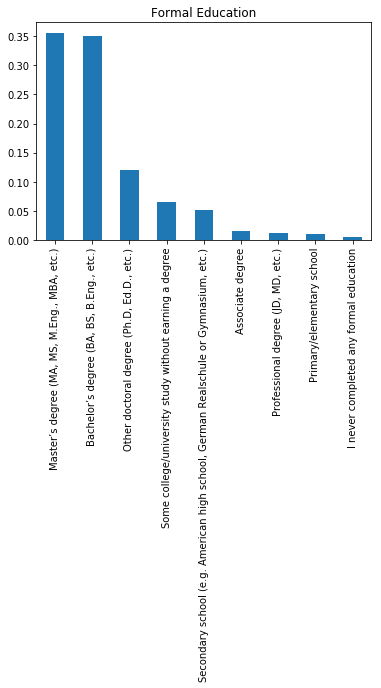

In [13]:
ed_vals = df.EdLevel.value_counts()#Provide a pandas series of the counts for each FormalEducation status

# The below should be a bar chart of the proportion of individuals in your ed_vals
# if it is set up correctly.

(ed_vals/df.shape[0]).plot(kind="bar");
plt.title("Formal Education");

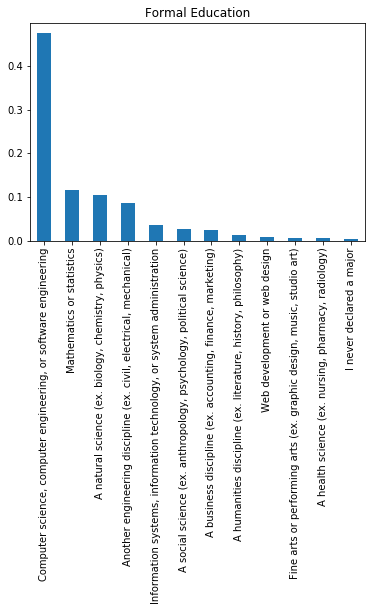

In [14]:
ed_vals = df.UndergradMajor.value_counts()#Provide a pandas series of the counts for each FormalEducation status

# The below should be a bar chart of the proportion of individuals in your ed_vals
# if it is set up correctly.

(ed_vals/df.shape[0]).plot(kind="bar");
plt.title("Formal Education");

In [16]:
df.ConvertedComp.mean()

142191.2698600901

In [17]:
df.WorkWeekHrs.mean()

42.47575384717948

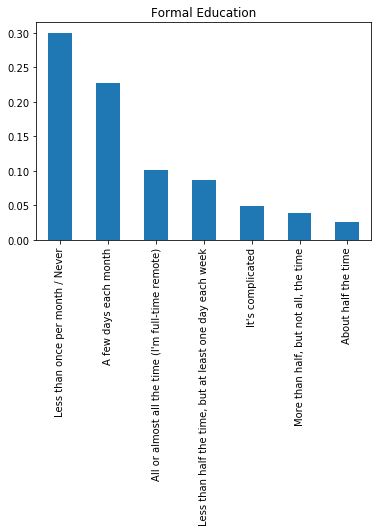

In [19]:
ed_vals = df.WorkRemote.value_counts()#Provide a pandas series of the counts for each FormalEducation status

(ed_vals/df.shape[0]).plot(kind="bar");
plt.title("Formal Education");

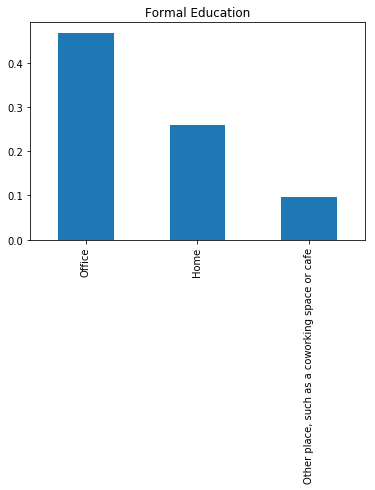

In [20]:
ed_vals = df.WorkLoc.value_counts()#Provide a pandas series of the counts for each FormalEducation status

(ed_vals/df.shape[0]).plot(kind="bar");
plt.title("Formal Education");

In [58]:
#pd.DataFrame(df.query("Professional == 'Professional developer' and (Gender == 'Male' or Gender == 'Female')").groupby(['Gender', 'FormalEducation']).mean()['Salary'])

In [78]:
lang_vals = df.LanguageWorkedWith.value_counts()[:19]  #Provide a pandas series of the counts for each FormalEducation status
lang_vals

#(lang_vals/df.shape[0]).plot(kind="bar");
#plt.title("Formal Education");

Python                                                    173
Python;R;SQL                                              109
Python;SQL                                                 84
Python;R                                                   81
Bash/Shell/PowerShell;Python;R;SQL                         72
Bash/Shell/PowerShell;Python                               69
R                                                          61
Bash/Shell/PowerShell;Python;SQL                           54
Bash/Shell/PowerShell;HTML/CSS;JavaScript;Python;SQL       49
C++;Python                                                 43
HTML/CSS;JavaScript;Python;SQL                             41
R;SQL                                                      39
HTML/CSS;JavaScript;Python                                 38
Bash/Shell/PowerShell;C++;Python                           32
Java;Python                                                32
Bash/Shell/PowerShell;HTML/CSS;JavaScript;Python;R;SQL     31
Bash/She

In [100]:
#df['LanguageWorkedWith']

In [101]:
#df['LanguageWorkedWith'][88504].split(';')

In [27]:
def total_count(df, col1, col2, look_for, delim=';'):
    '''
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count values from
    look_for - a list of strings you want to search for in each row of df[col1]
    delim - string delimiter value to break up the string by

    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up
    '''
    new_df = defaultdict(int)
    #loop through list of ed types
    for val in look_for:
        #loop through rows
        for idx in range(df.shape[0]):
            #if the type is in the row add 1
            if val in df[col1][idx].split(delim):
                new_df[val] += int(df[col2][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df

In [ ]:
def count_lists(df, col1, col2, look_for, delim=';'):
    '''
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count values from
    look_for - a list of strings you want to search for in each row of df[col1]
    delim - string delimiter value to break up the string by

    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up
    '''
    new_df = defaultdict(int)
    #loop through list of ed types
    for val in look_for:
        #loop through rows
        for idx in range(df.shape[0]):
            #if the type is in the row add 1
            if val in df[col1][idx].split(delim):
                new_df[val] += int(df[col2][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df

In [28]:
def clean_and_plot(df, possible_vals, col='LanguageWorkedWith', title='Method of Educating Suggested', plot=True):
    '''
    INPUT 
        df - a dataframe holding the CousinEducation column
        possible_vals - list of possible values to search for
        title - string the title of your plot
        axis - axis object
        plot - bool providing whether or not you want a plot back
        
    OUTPUT
        study_df - a dataframe with the count of how many individuals
        Displays a plot of pretty things related to the CousinEducation column.
    '''
    study = df[col].value_counts().reset_index()
    study.rename(columns={'index': 'method', col: 'count'}, inplace=True)
    study_df = total_count(study, 'method', 'count', possible_vals)

    study_df.set_index('method', inplace=True)
    if plot:
        (study_df/study_df.sum()).plot(kind='bar', legend=None);
        plt.title(title);
        plt.show()
    props_study_df = study_df/study_df.sum()
    return props_study_df



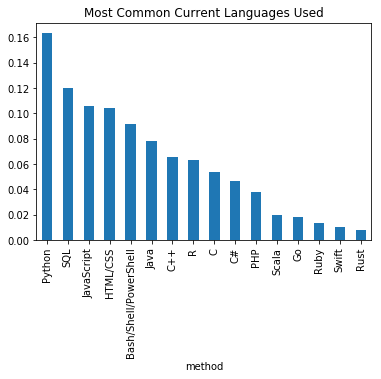

In [29]:
lang_vals = ["PHP","Python","R","SQL","Java","Bash/Shell/PowerShell","HTML/CSS","JavaScript","C","C++",
                 "C#","Swift", "Go", "Scala", "Rust", "Ruby", "Other(s)"]
props_df = clean_and_plot(df, lang_vals, col='LanguageWorkedWith', title='Most Common Current Languages Used')

In [104]:
lang_vals = df.LanguageDesireNextYear.value_counts()#Provide a pandas series of the counts for each FormalEducation status
lang_vals

#(lang_vals/df.shape[0]).plot(kind="bar");
#plt.title("Formal Education");

Python                                                  226
Python;R;SQL                                             98
Python;R                                                 89
Python;SQL                                               88
C++;Python                                               64
Bash/Shell/PowerShell;Python                             45
R                                                        43
Bash/Shell/PowerShell;Python;R;SQL                       41
JavaScript;Python                                        37
HTML/CSS;JavaScript;Python                               37
Other(s):                                                36
Java;Python                                              32
Bash/Shell/PowerShell;Python;SQL                         31
Python;Other(s):                                         30
Go;Python                                                29
Python;Scala                                             28
Python;Rust                             

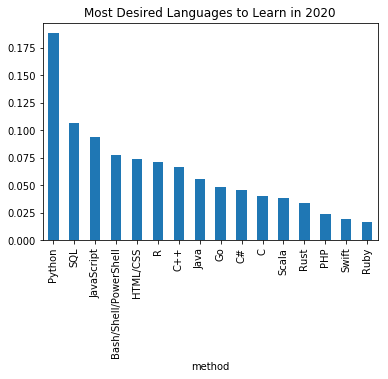

In [110]:
props_df = clean_and_plot(df, lang_vals, col='LanguageDesireNextYear', title='Most Desired Languages to Learn in 2020')

In [23]:
#other_ed_vals = df.EduOther.value_counts()#Provide a pandas series of the counts for each CousinEducation status

#other_ed_vals # assure this looks right

In [24]:
lang_vals = df.DatabaseWorkedWith.value_counts()[:19]  #Provide a pandas series of the counts for each FormalEducation status
lang_vals

#(lang_vals/df.shape[0]).plot(kind="bar");
#plt.title("Formal Education");

MySQL                                265
Microsoft SQL Server                 247
PostgreSQL                           234
SQLite                               143
PostgreSQL;SQLite                    124
MySQL;SQLite                         119
Microsoft SQL Server;MySQL           109
MongoDB                               99
Other(s):                             93
MySQL;PostgreSQL;SQLite               88
MySQL;PostgreSQL                      69
Oracle                                60
Microsoft SQL Server;MySQL;SQLite     54
Microsoft SQL Server;SQLite           53
MySQL;Oracle                          52
Microsoft SQL Server;Oracle           50
Microsoft SQL Server;PostgreSQL       47
MongoDB;MySQL                         47
MongoDB;MySQL;SQLite                  45
Name: DatabaseWorkedWith, dtype: int64

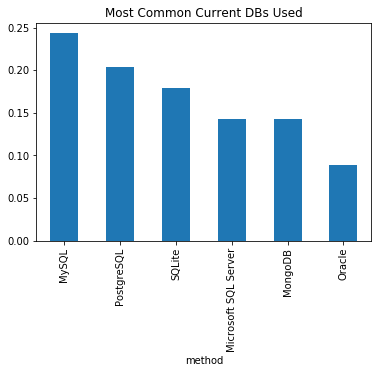

In [30]:
lang_vals = ["MySQL","Microsoft SQL Server","PostgreSQL","SQLite","MongoDB","Oracle", "Other(s)"]
props_df = clean_and_plot(df, lang_vals, col='DatabaseWorkedWith', title='Most Common Current DBs Used')